# Manta Fingerprint Identification with Principal Computer Vision Algorithms

I've been searching for a project to do on pattern matching with computer vision fundamentals for a while. I threw around some ideas in my head like detecting different machine bolts, nuts, and screws to categories them, or detecting and identifying playing cards, or looking at human fingerprint detection. As usual, I had to turn to the ocean for inspiration.

As I was doing a night scuba dive with manta rays with a friend of mine, I couldn't help myself to think about how cool it would be to identify manta rays by their unique patterns. I noticed that on the bottom of a manta ray exists, what appears to be, a unique set of black splatters. If I could apply the same principles of human fingerprint identification to manta rays, perhaps I could uniquely identify the individual!

Turns out, I was definetely onto something. Manta rays do indeed have a unique pattern on their underside that scientists have used to identify individuals. In fact, the original researchers of this created an organization called [Manta Matcher](https://mantamatcher.org/) that has compiled a database of **12,658** different animals from around the world!

The original research paper [Manta Matcher: automated photographic identification of manta rays using keypoint features](https://pubmed.ncbi.nlm.nih.gov/23919138/) provides a very comprehensive overview of the algorithm they implemented using a combination of basic computer vision algorithms. Since this paper was published in 2013, much of the modern deep learning techniques that have been developed weren't avaliable at the time. So, pulling techniques descriped in the paper, I will reimplement their technique and see if I can automate some of the steps they took to identify manta rays.

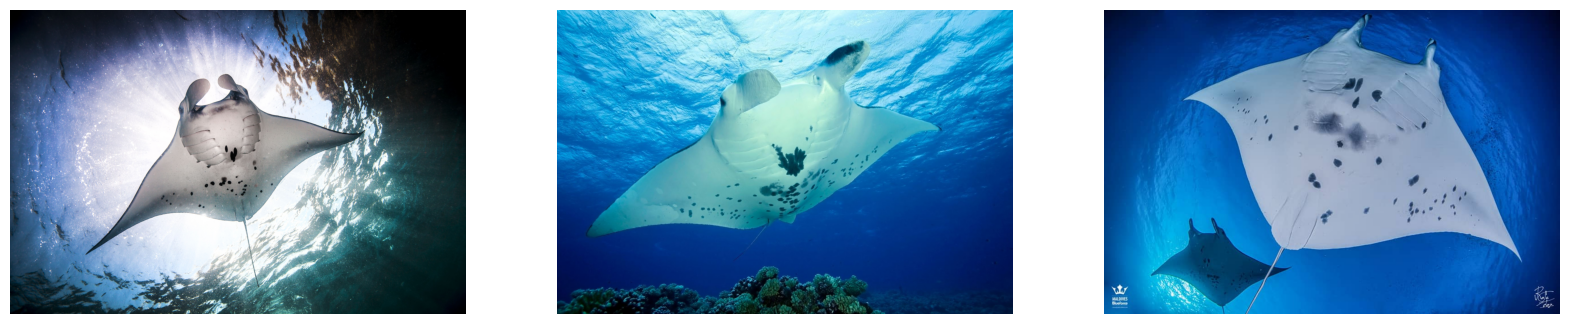

In [1]:
import matplotlib.pyplot as plt
import cv2

frame_1 = cv2.imread('manta_1.jpg')
frame_2 = cv2.imread('manta_2.jpg')
frame_3 = cv2.imread('manta_3.jpg')

fig, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].imshow(cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB))
ax[1].axis('off')
ax[2].imshow(cv2.cvtColor(frame_3, cv2.COLOR_BGR2RGB))
ax[2].axis('off')

plt.show()

## The Plan

The original paper lays out the algorithm very simply:

- Manually align the orientation of the manta ray in the image to a standard.

- Manually select a region of interest (ROI) around the manta ray's belly.

- Enchance the image by applying noise removal and adaptive contrast equalization.

- Identify unique features from the spotted patterns on the manta ray's belly.

- Match the features to a database of known manta rays.

Obviously, since the first two are manual steps, this is where we might apply some automation. The rest are still very applicable principal computer vision algorithms, even in the world of AI and deep learning.

For the first step, we can automate this in a series of two steps. First, we can identify the manta in the image using an **object detection** model. If we can identify the manta, we can then run a **pose estimation** model to capture the orientation of the manta. This will allow us to do two things: 1) rotate the image to a standard orientation, and 2) crop the image to the region of interest.

Now, in this notebook, I won't be able to collect a large enough dataset for the object detection or pose estimation models (not until I collect enough data). Instead, we can manually annotate the above 3 images and use them as a test to implement the rest of the algorithm.

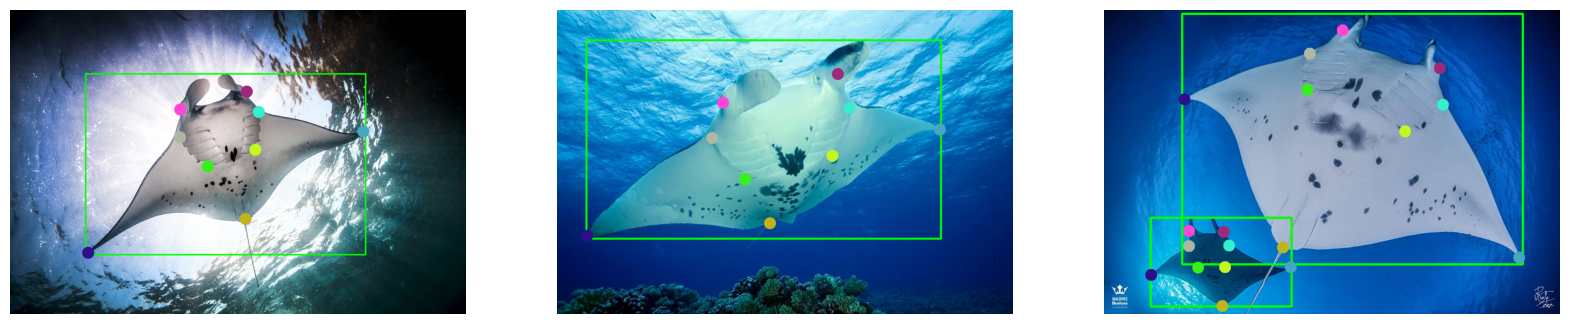

In [14]:
import json
import numpy as np

mantas = []

keypoints_coco = json.load(open('keypoints_coco.json'))
instances_coco = json.load(open('instances_coco.json'))

keypoint_colors = [(np.random.rand(3) * 255).astype(int) for _ in range(9)]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for image, ax in zip(instances_coco['images'], axes):
    frame = cv2.imread(image['file_name'])
    
    image_size = (image['width'], image['height'])
    line_width = int(min(image_size) * 0.005)
    circle_radius = int(min(image_size) * 0.02)

    instance_annos = [a for a in instances_coco['annotations'] if a['image_id'] == image['id']]
    keypoint_annos = [a for a in keypoints_coco['annotations'] if a['image_id'] == image['id']]
    
    for index, (instance, keypoints) in enumerate(zip(instance_annos, keypoint_annos)):
        
        manta = {
            'image': image['file_name'],
            'box': instance['bbox'],
            'keypoints': np.array(keypoints['keypoints']).reshape(-1, 3)[:, :2]
        }
        
        mantas.append(manta)
        
        x, y, w, h = manta['box']
        cv2.rectangle(frame, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), line_width)
        
        c = 0
        for i in range(len(manta['keypoints'])):
            x, y =  manta['keypoints'][i]
            color = keypoint_colors[c]
            cv2.circle(frame, (int(x), int(y)), circle_radius, color.tolist(), -1)
            c += 1
    
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

Using object detection provides a few benefits in the context of this implements.

- For the sake of computational efficiency, we only want to run the pose estimation if we have a high confidence that a manta ray exists in the image. In combination with certain brightness filters, we can greatly increase efficiency.

- We can use the bounding box of the object detection to crop the image to a certain region of interest. This will allow us to focus more on an individual manta ray, while also reducing the size of the image needed to be processed. In marine environments, studying animals that are social and congregate in groups often results in multiple animals captured in the same image. This can increase the possibility of false positives in the pose estimation and the unique fingerprint identification from one animal to another.

Using the object detection as a filter, we can then process the pose estimation model. And this model provides us again with several benefits.

- We now know the standard orientation of the manta ray. We can now rotate the animal in the frame to a standard: head facing to the top of the image with the rear facing to the bottom.

- In this particular animal, we have selected 9 keypoints: the 2 eyes, the outside point of the top gill flaps, the outside points of the bottom gill flaps, the tips of the pectoral fins, and the base of the tail or bottom of the pelvic fins. Generally speaking, we don't need all of these keypoints to determine the unique fingerprint, or even the orientation of the animal. We could rely on a subset. But this adds an additional layer of robustness serving, again, several purposes. 1) We can use the gill keypoints with the tail keypoint to crop a region (similar to the region in the original paper) around the belly of the manta ray. 2) With all of this keypoints, we can be more confident that we have captured a manta ray that is only translated or rotated in the 2D plane and not in the 3D plane. The biomarkers will not match nearly as well if the manta ray is rotated in the 3D plane. And finally, 3) we can help identify the manta ray even more if we know the sex of the animal. The pelvic fins look distinctly different depending on the sex.

Okay, with all that background, we can work on reimplementation. Let's start with orientation alignment for the manta.

In [15]:
# orientate keypoints to be relative to the bounding box
# Since we are going to crop out the rest of the image
for manta in mantas:
    x, y, w, h = manta['box']
    keypoints = manta['keypoints']
    for i in range(len(keypoints)):
        keypoints[i][0] -= x
        keypoints[i][1] -= y

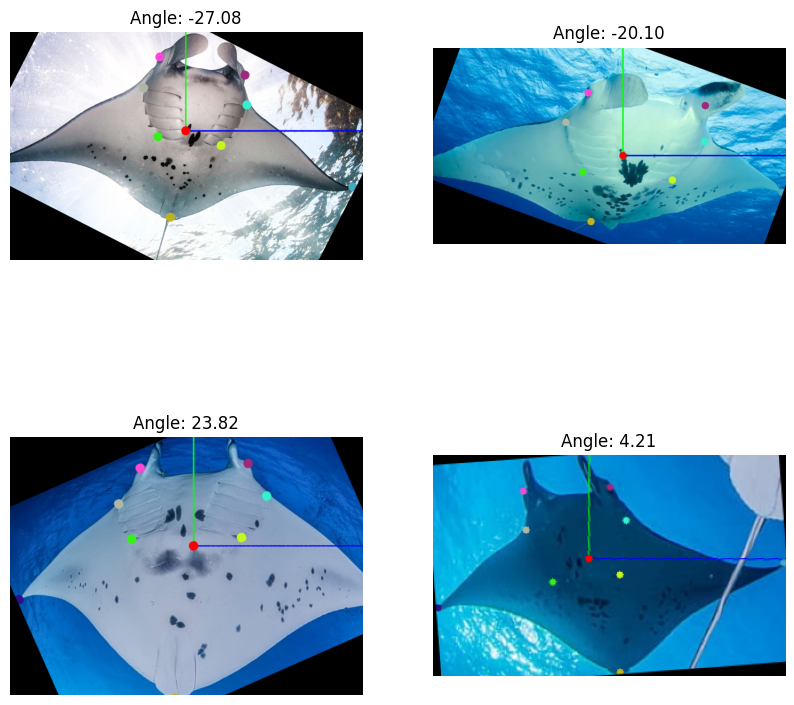

In [16]:
def get_body_part(part, keypoints):
    mapp = {"eye_1": 0, "eye_2": 1, "gill_1": 2, "gill_2": 3, "gill_3": 4, "gill_4": 5, "pectoral_1": 6, "pectoral_2": 7, "pelvic": 8}
    return keypoints[mapp[part]]


def manta_orientation(manta):
    # use all the keypoints to compute the orientation
    points = manta['keypoints']
    
    # PCA is used to compute the orientation of the points
    # https://docs.opencv.org/4.x/d1/dee/tutorial_introduction_to_pca.html
    mean, eigen_vec, eigen_val = cv2.PCACompute2(points, np.array([]))
    
    center = (int(mean[0, 0]), int(mean[0, 1]))
    axis_1 = (center[0] + eigen_vec[0, 0] * eigen_val[0, 0], center[1] + eigen_vec[0, 1] * eigen_val[0, 0])
    axis_2 = (center[0] - eigen_vec[1, 0] * eigen_val[1, 0], center[1] - eigen_vec[1, 1] * eigen_val[1, 0])
    
    angle = np.arctan2(eigen_vec[0, 1], eigen_vec[0, 0])
    
    return center, angle, axis_1, axis_2


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for manta, ax in zip(mantas, axes.flatten()):
    frame = cv2.imread(manta['image'])
    
    # crop the frame to the bounding box of the manta
    x, y, w, h = manta['box']
    frame = frame[int(y):int(y+h), int(x):int(x+w)]
    
    manta['orientation'] = manta_orientation(manta)

    center, angle, axis_1, axis_2 = manta['orientation']
    
    image_size = (frame.shape[1], frame.shape[0])
    line_width = max(int(min(image_size) * 0.005), 1)
    circle_radius = max(int(min(image_size) * 0.02), 1)

    cv2.line(frame, center, (int(axis_1[0]), int(axis_1[1])), (255, 0, 0), line_width)
    cv2.line(frame, center, (int(axis_2[0]), int(axis_2[1])), (0, 255, 0), line_width)
    cv2.circle(frame, center, circle_radius, (0, 0, 255), -1)
    
    angle = np.rad2deg(angle)
    
    for i in range(len(manta['keypoints'])):
        x, y =  manta['keypoints'][i]
        color = keypoint_colors[i]
        cv2.circle(frame, (int(x), int(y)), circle_radius, color.tolist(), -1)
    
    rows, cols, _ = frame.shape
    frame_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    frame = cv2.warpAffine(frame, frame_matrix, (cols, rows))
    
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.set_title('Angle: {:.2f}'.format(angle))
    ax.axis('off')
    
plt.show()

Wow! Alright a lot of information to digest. Let's break it down.

First, given the keypoints detected, we assume that there is are geometric properties natural to the skeleton of the manta ray such that we can orient the manta ray in a standard direction. We assume that spatially the manta ray is longer than it is wide. This will give us two axes one which will be from the head to the tail. The other, from left to right. As long as we select the right axis, we can then rotate the image where the head is towards the top of the image.

This method is not completely perfect as 3D rotations are still present which orientate the skeleton in a different direction. But with the sample images, we see that the <b style="color: green">green</b> axis pierces the head in every one. The bottom-left image is nearly perfect as it is probably the best captured image of the 2d representation of the underside.

To find this special geometric axis of the manta, we use the keypoints provided by the pose estimation model and calculate the "axis of least second moment" or "axis of least inertia". This axis will pass through the moment of inertia (in physics terms the center of mass). A lot of linear algebra and calculus is involved in this calculation. A very good explanation can be found here [Geometric Properties | Binary Images](https://www.youtube.com/watch?v=ZPQiKXqHYrM).

Computationally, we use PCA (Principal Component Analysis) to calculate the eigenvectors of the matrix of keypoints. If you are familar with PCA, you know that it is a method of reducing dimensionality of a dataset such that the variance of the dataset is maximized. In a machine learning regression context, we use this to filter out features that are not important. In this context, we want to know the overall direction, and center position, of the keypoints. Since the keypoints are generally distributed over the entire body, this should be close to the overall orientation of the animal. OpenCV provides a comprehensive tutorial on this [Introduction to Principal Component Analysis (PCA)](https://docs.opencv.org/4.x/d1/dee/tutorial_introduction_to_pca.html) for which I pulled reference code from.

Now, admittedly, we could improve on this. A more accurate description to compute the center of mass would be to know the segmentation of the manta and use a binary mask of the animal to determine the overall orientation. We could further improve this algorithm by adding addition checks to ensure that the axis is correct: like making sure the axis passes through the head and tail and ensuring that the distance from the left eye to the axis and the right eye to the axis are similar in length.

Regardless, given how much the body of the manta ray bends and twists, this method will given variable centers of mass throwing the axis off. We make an assumption here that the pose estimation model is trained on a dataset of well taken images where the manta ray underside is mostly parallel to the image plane.

With all this out of the way, we can continue to the next step and select the region of interest. This should be straight forward now.

In [21]:
for manta in mantas:
    center, angle, axis_1, axis_2 = manta['orientation']

    points = manta['keypoints'].copy()
    
    for i in range(len(points)):
        x, y = points[i]
        x -= center[0]
        y -= center[1]

        x_new = x * np.cos(-angle) - y * np.sin(-angle)
        y_new = x * np.sin(-angle) + y * np.cos(-angle)
        
        points[i] = [x_new + center[0], y_new + center[1]]
        
    manta['rotated_keypoints'] = points

First we need to rotate the keypoints about the center of mass to align the points with the standard orientation. If we recall from trigonometry, we can rotate a point about the origin by the following formula:

```python
x' = x * cos(theta) - y * sin(theta)
y' = x * sin(theta) + y * cos(theta)
```

A refresher for this math can be found here [Rotation of a point about another point](https://www.youtube.com/watch?v=nu2MR1RoFsA). And to consider it in a matrix operation, check this out: [Rotation Matrix for Coordinate Transformation](https://www.youtube.com/watch?v=-HcDl_gyeMs)

We can then construct a convex hull from the keypoints, and crop out the region of interest of the manta ray body.

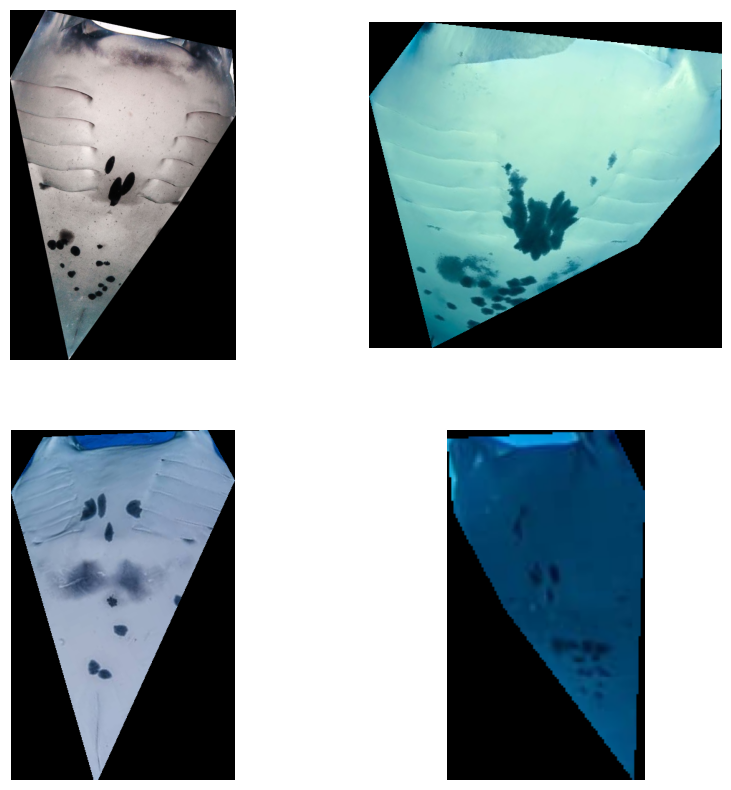

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for manta, ax in zip(mantas, axes.flatten()):
    frame = cv2.imread(manta['image'])
    
    # crop the frame to the bounding box of the manta
    x, y, w, h = manta['box']
    frame = frame[int(y):int(y+h), int(x):int(x+w)]
    
    image_size = (frame.shape[1], frame.shape[0])
    line_width = max(int(min(image_size) * 0.005), 1)
    circle_radius = int(min(image_size) * 0.02)

    center, angle, axis_1, axis_2 = manta['orientation']
    
    rows, cols, _ = frame.shape
    frame_matrix = cv2.getRotationMatrix2D(center, np.rad2deg(angle), 1)
    frame = cv2.warpAffine(frame, frame_matrix, (cols, rows))
    
    # we discard the pectoral fin keypoints to focus
    # on the central body of the manta
    hull = np.array([
        get_body_part("eye_1", manta['rotated_keypoints']),
        get_body_part("eye_2", manta['rotated_keypoints']),
        get_body_part("gill_1", manta['rotated_keypoints']),
        get_body_part("gill_2", manta['rotated_keypoints']),
        get_body_part("gill_3", manta['rotated_keypoints']),
        get_body_part("gill_4", manta['rotated_keypoints']),
        get_body_part("pelvic", manta['rotated_keypoints']),
    ]).astype(np.int32)
    
    hull = cv2.convexHull(hull)
    
    mask = np.zeros_like(frame)
    cv2.fillPoly(mask, [hull], (255, 255, 255))
    frame = cv2.bitwise_and(frame, mask)
    
    hull_box = cv2.boundingRect(hull)
    x, y, w, h = hull_box
    
    frame = frame[y:y+h, x:x+w]
    
    manta['cropped_hull'] = frame.copy()
    
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    
plt.show()

Amazing! The selection for the keypoints to use in the convex hull is very important and it largely depends on the biology of the animal. Looking for expert opinion on this, we know that the original research paper simply selects a 2D bounding box with the mantas mid section centered. This mid section covers the body from the top gills to just above the pelvic fins. But, others have also deployed a very similar technique to what we are choosing which is described here: [Manta Trust - Manta Base](https://www.mantatrust.org/mantabase)

Either way, we can be confident that this selected region will have enough unique features to identify the manta ray. We can now progress to the next step of image enhancement.

In the original paper, they found that the best enhancement techniques was a combination of median blur to reduce noise with contrast-limited adaptive
histogram equalization or CLAHE.

Median blur is simply a convolution that replaces the select pixel with the median value of the kernel. The larger the kernel, the more noise is removed but the more detail is lost. Median blur is very common to remove "salt and pepper" noise in images, but is not that most robust to detail retention. Bilateral filtering is a more advanced technique, deploying a non-linear filter, that is more robust to detail retention. It deploys a guassian blur kernel where only the pixels that are similar in intensity are considered. Intuition would tell us that this may be better suited for our task since we want to preserve as much detail to the black sploches as possible. For this tutorial, we will stick with median blur.

As usually, OpenCV provides a very good tutorial on image filtering: [2D Convolution (Image Filtering)](https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)

CLAHE is a different technique used for contrast adjustment. Generally, this is where the histogram of colors of a grayscale image are anaylzed, and a threshold is applied at some point (usually the median or some low extremity) to adjust the contrast. CLAHE makes that technique "adaptive" by appling it acrossed local regions of the image. The paper describes this as useful since images taken of mantas feature a wide range of lighting conditions due to camera flashes, sun light, and water clarity. This is a very good tutorial on CLAHE: [Histogram Equalization](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html)

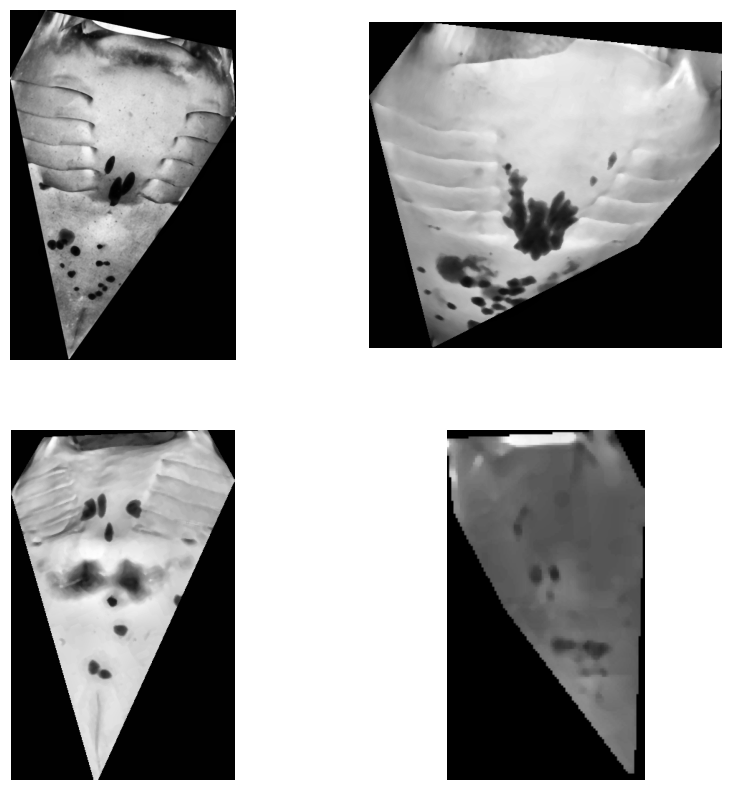

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for manta, ax in zip(mantas, axes.flatten()):
    frame = manta['cropped_hull'].copy()
    
    # convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # apply median filter to smooth the image
    gray = cv2.medianBlur(gray, 5)
    
    # apply adaptive thresholding to binarize the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    manta['gray'] = gray
    
    ax.imshow(gray, cmap='gray')
    ax.axis('off')

plt.show()

Trying different hyperparameters for the bilateral filter and CLAHE will be important. Further tuning would be required to find the best combination after we collect a larger dataset. For now, this works pretty well!

Now, we can get to the final step of identifying the unique features of the manta ray. We will deploy a technique called SIFT (Scale-Invariant Feature Transform) for this problem. After applying contrast equalization, noise removal, and rotating the image to a standard orientation, there still won't be perfect continuity from one image to the next. SIFT is a very robust algorithm that can find blobs in the image that are invariant to these minor changes (assuming the changes are not too drastic).

SIFT is a very mathematical algorithm and works by identifying keypoint blobs, and calculating there local gradient given the intensity of the pixels around the blob. These keypoints and their gradients (or vectors) are then used to create a unique set of markers that can be used to match to other images if similar keypoints are found.

OpenCV has a great tutorial here: [Introduction to SIFT (Scale-Invariant Feature Transform)](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html). But an amazing youtube series on the math is available here: [Edge Detection | Boundary Detection | SIFT Detector](https://www.youtube.com/watch?v=7AlwDYmjrcs&list=PL2zRqk16wsdqXEMpHrc4Qnb5rA1Cylrhx)

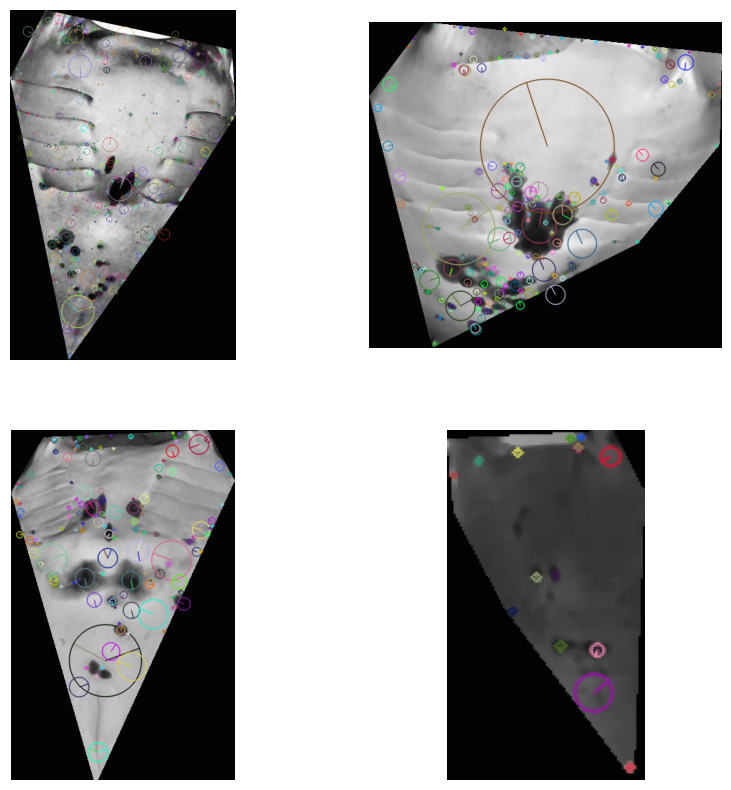

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for manta, ax in zip(mantas, axes.flatten()):
    gray = manta['gray'].copy()
    
    sift = cv2.SIFT_create()
    
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    manta["sift"] = {
        "keypoints": keypoints,
        "descriptors": descriptors
    }
    
    gray = cv2.drawKeypoints(gray, keypoints, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    ax.imshow(gray, cmap='gray')
    ax.axis('off')

plt.show()

These plots represent the blob keypoints detected an the overall vector of the gradient in that blob. Depending on the clarity of the image, we may get more or less matches than we would like. Multiple images of the same animal should be captured to have different descriptors in different scales, angles, and lighting conditions. You can see in the bottom-right image, this was the most difficult to detect features as the brightness and focus is very poor.

Let's take a look at the features to get a better understanding of what we are looking at.

In [73]:
keypoint = mantas[0]['sift']['keypoints'][0]

keypoint.pt, keypoint.size, keypoint.angle, keypoint.response, keypoint.octave

((7.386290073394775, 213.12411499023438),
 4.260604381561279,
 98.21598052978516,
 0.031134868040680885,
 12321024)

The key points represent the markers that are drawn on the image. We see the center, the size and respective angle of the blob.

In [71]:
descriptor = mantas[0]['sift']['descriptors'][0]

descriptor.shape, descriptor

((128,),
 array([  1.,  36.,  38.,   0.,   0.,   0.,   0.,   0.,  16.,  38.,  31.,
          1.,   1.,   9.,   4.,   6.,  63.,   7.,   1.,   0.,   0.,   6.,
         26., 138.,   3.,   0.,   0.,   0.,   0.,  11.,  99.,  79.,  12.,
         54.,  64.,   0.,   0.,   0.,   1.,   9.,  83.,  68.,  22.,   0.,
          0.,   0.,  13.,  31., 138.,  42.,  10.,   3.,   0.,   0.,   7.,
         75.,  31.,   7.,  58.,  64.,   3.,  12.,  34.,  33.,  82., 138.,
         26.,   0.,   0.,   0.,   4.,  32., 104.,  35.,   1.,   2.,   7.,
         17., 111., 111., 132.,  65., 138.,  59.,  15.,  14.,  27.,  23.,
          9.,  13., 138., 138.,   0.,   0.,   0.,   0.,  25.,  71.,   7.,
          0.,   0.,   0.,   0.,   1.,  44.,  24.,   0.,   1.,   4.,   8.,
          9.,  11.,   0.,   1.,  18.,  17.,   9.,   7.,   3.,   0.,   0.,
          0.,  16.,  20.,   0.,   0.,   0.,   0.], dtype=float32))

The descriptors represent the vector of binned gradients around the blob. A section, 16x16, is taken around the keypoint, and a tile is moved over this area. This tiled region and it's gray scale pixel values are then put into a histogram with the largest bin being the output of the descriptor. A better description of the method is found in the youtube lecture series above.

Effectively, these descriptors represent a unique fingerprint for that specific blob and can be used to compare to other blobs in other instances. A comparison is made, and based on the similarity of the descriptors, a match is found. Many different methods are avaliable to compare these descriptors, employing distance metrics like Euclidean distance or cosine similarity. These methods deserve their own tutorial series themselves as they cover a wide range of topics in machine learning and computer vision.

A robust library for different methods of vector similarity is made avaliable by Facebook called [FAISS](https://github.com/facebookresearch/faiss). It provides Python bindings to C++ code that can even be deployed on GPUs.

OpenCV provides there own feature matching algorithm that can be used to compare matched features. You can review it here: [Feature Matching](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html). It likely employs similar vector similarity methods as FAISS.

But I wanted to use a more popular choice for arbitrary vector search to show how a potential database of hundreds or even millions of manta ray fingerprints could be stored and searched. Let's try to reformat the keypoints and descriptors to see how they could be embedded into a search index for a database.

In [113]:
import faiss

indicies = []
embeddings = []

index_s = 0
index_c = 0
for i, manta in enumerate(mantas):
    sift = manta['sift']
    
    for descriptor in sift['descriptors']:
        embeddings.append(descriptor)

    index_c += len(sift['descriptors']) - 1

    # we store the range of indicies for each manta. The position
    # of the array is the index for the manta in our list
    indicies.append((index_s, index_c))
    
    index_s = index_c + 1

indicies = np.array(indicies)
embeddings = np.array(embeddings).astype(np.float32)

dimensions = embeddings.shape[1]

index = faiss.IndexFlatL2(dimensions)

index.add(embeddings)

print('Indicies:', indicies.shape)
print('Embeddings:', embeddings.shape)

Indicies: (4, 2)
Embeddings: (1087, 128)


In [114]:
indicies

array([[   0,  674],
       [ 675,  910],
       [ 911, 1066],
       [1067, 1083]])

FAISS is an incredible complex library with many optimizations for searching very large datasets. Anything that can be represented as a vector, where you need to search for similar vectors, can be used with FAISS. So I won't go too far into the details (maybe in another tutorial). For starters, a wonderful tutorial series on youtube can be found here: [Vector Similarity Search and Faiss Course](https://www.youtube.com/watch?v=AY62z7HrghY&list=PLIUOU7oqGTLhlWpTz4NnuT3FekouIVlqc)

What I have done is taken each of the descriptors, and compiled them into one large matrix. To make sure we keep track of the descriptors and which manta ray they belong to, I created a second matrix which keeps track of the indicies.

Next, I create a FAISS index called `faiss.IndexFlatL2`. It's base implementation will use a brute-force method to search for similar vectors using L2, or, Euclidean distance. This is a very simple method and is not the most efficient. But it is a good starting point for our tutorial.

Using any set of descriptors, we can then search for the most similar descriptors in that index. If we use the descriptors of the first manta, lets examine what the results are.

In [118]:
embeddings = mantas[0]['sift']['descriptors']
embeddings = np.array(embeddings).astype(np.float32)

k = 5
distances, neighbors = index.search(embeddings[0].reshape(1, -1), k)

print('Neighbors:', neighbors)
print('Distances:', distances)

Neighbors: [[   0 1078 1077  649 1058]]
Distances: [[     0. 142767. 148252. 153261. 168205.]]


Searching the index, we can pass in a `k` parameter which will return the `k` most similar vectors. For the first descriptor blob of the first manta, we can see the top result is `0`. Which is literally an exact match to itself! In addition, we see that the distance to the next most similar vector is way higher than the first.

Now let's pass in all the descriptors of the first manta, and view the single top result.

In [117]:
distances, neighbors = index.search(embeddings, 1)

for i, (start, end) in enumerate(indicies):
    matches = np.sum((neighbors >= start) & (neighbors <= end))
    print(f'Total descriptor for manta {i}: {matches}')

Total descriptor for manta 0: 675
Total descriptor for manta 1: 0
Total descriptor for manta 2: 0
Total descriptor for manta 3: 0


And we see the exact result we are looking for. All of the descriptors of the first manta are matched to the first manta vectors in the faiss index. Now this worked out such that there were 0 matches to any other mantas in the index. But since we have such a small index, this is not surprising. With a larger index (more mantas), we could expect to see more arbitrary matches. In addition, more advanced methods of indexing and searching could be used such that come with a trade-off of speed and accuracy.

## Conclusion

What a fun project to work on. The ocean will continue to be a source of inspiration for me and I hope to keep working on projects like this in the future. I hope this tutorial and project is as fun to read as it was to write.